In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc 

% matplotlib inline

In [ ]:
# Obtain all labels
response = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969])

In [2]:
df = pd.read_csv('data/train_date.csv.zip', index_col=0)

C:\Users\home\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [11]:
date_start = df.min(axis=1)
date_end = df.max(axis=1)

In [16]:
del df

gc.collect()

### Create dataframe with start date and response

In [370]:
# start date, end date, duration, response
date = pd.concat([date_start, date_end, date_end-date_start], axis=1)

date.columns = ['date_start', 'date_end', 'date_duration']
# date.sort_values(by=['date_start', 'Id'], inplace=True)
date.dropna(axis=0, inplace=True)
date['Response'] = response

### Row distance to the previous and next error when rows are sorted by ID
$P(\text{error}\mid d=1)=0.054$, where $d$ is the distance to the previous or next error.

$P(\text{error}\mid d=1)$ is the same for $d$ measured from the previous or next error.

In [371]:
# Sort by ID, calculate row distance to last error
date.reset_index(inplace=True)
date['dist_1'] = np.zeros(len(date), dtype=np.int64)
date.loc[date.Response==1, 'dist_1'] = date.index[date.Response==1]
date['dist_1'] = date['dist_1'].shift(1).fillna(-1)
date.dist_1 = date.dist_1.cummax()
date.dist_1 = date.index - date.dist_1.astype(int)

date['dist_3'] = 9999999*np.ones(len(date), dtype=np.int64)
date.loc[date.Response==1, 'dist_3'] = date.index[date.Response==1]
date.dist_3 = date.dist_3.shift(-1).fillna(9999999).astype(int)
date.dist_3 = date.dist_3.iloc[::-1].cummin().iloc[::-1]
date.dist_3 = date.dist_3 - date.index

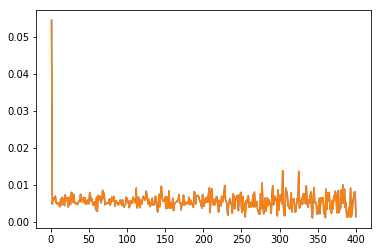

In [372]:
# Plot probability of error as distance, P(error|row distance to last error sorted by ID)
dist_1 = date.groupby('dist_1').Response.agg(['mean', 'sum', 'count'])
N = 400
plt.plot(dist_1.index.tolist()[:N], dist_1['mean'].values[:400])
dist_3 = date.groupby('dist_3').Response.agg(['mean', 'sum', 'count'])
plt.plot(dist_3.index.tolist()[:N], dist_3['mean'].values[:400])

The smallest 5 row distances and its statistics

In [373]:
dist_1.head()

,mean,sum,count
dist_1,,,
1,0.054514,375,6879
2,0.004767,31,6503
3,0.006489,42,6472
4,0.005910,38,6430
5,0.006101,39,6392


### ID difference to the previous and next row when sorted by `date_start` and `ID`
$P(\text{error}\mid d=1)=0.012$, where $d$ is the ID difference to the previous row

$P(\text{error}\mid d=1)=0.073$, where $d$ is the ID difference to the next row

In [374]:
# Distance in ID when sorted by date_start and ID, P(error|ID difference to previous one when sorted by start date and ID)
date.sort_values(['date_start', 'Id'], inplace=True)
date['dist_2'] = date.Id.diff().fillna(9999999).astype(int)
dist_2 = date.groupby('dist_2').Response.agg(['mean', 'sum', 'count'])
dist_2 = dist_2.loc[(dist_2['count']>100)]
dist_2

,mean,sum,count
dist_2,,,
1,0.012493,446,35700
2,0.006972,32,4590
3,0.016275,9,553
2174,0.000000,0,103


In [375]:
# Distance in ID when sorted by date_start and ID, P(error|ID difference to next one when sorted by start date and ID)
date.sort_values(['date_start', 'Id'], inplace=True)
date['dist_4'] = date.Id.diff(-1).fillna(9999999).astype(int)
dist_4 = date.groupby('dist_4').Response.agg(['mean', 'sum', 'count'])
dist_4 = dist_4.loc[(dist_4['count']>100)]
dist_4.sort_values('mean', ascending=False)

,mean,sum,count
dist_4,,,
-1,0.073866,2637,35700
-2,0.053159,244,4590
-3,0.039783,22,553
-2174,0.000000,0,103


### Check the distribution of features
It seems that these three features can identify most of the errors

Is it possitive to **make time granularity larger** and improve performance, as indicated by `1374.49` and `1374.48` below?

In [376]:
# The `date_start` with the most errors
date.groupby('date_start').Response.sum().sort_values(ascending=False).head()

date_start
1374.49    17
1374.48    15
1291.64    12
1373.25    11
1374.99    11
Name: Response, dtype: int64

In [377]:
date.loc[((date['date_start']==1374.99)) & (date['Response']==1)]
# date.loc[((date['date_start']==1374.49) | (date['date_start']==1374.48)) & (date['Response']==1)]

,Id,date_start,date_end,date_duration,Response,dist_1,dist_3,dist_2,dist_4
357930,716735,1374.99,1376.70,1.71,1,80,70,15461,-1
390874,782676,1374.99,1376.70,1.71,1,480,1,65940,-1
390875,782677,1374.99,1376.70,1.71,1,1,341,1,-1
425145,851325,1374.99,1376.70,1.71,1,152,139,56885,-1
426797,854665,1374.99,1376.70,1.71,1,132,1,3339,-1
426798,854666,1374.99,1376.70,1.71,1,1,31,1,-1070
427327,855737,1374.99,1376.70,1.71,1,122,51,1,-1
432239,865475,1374.99,1376.70,1.71,1,5,105,9735,-1
435292,871644,1374.99,1376.70,1.71,1,256,4,6168,-114358
492273,986002,1374.99,1376.70,1.71,1,49,488,114358,-5365


In [378]:
date.loc[((date['date_start']==1374.99))]

,Id,date_start,date_end,date_duration,Response,dist_1,dist_3,dist_2,dist_4
167412,334882,1374.99,1499.19,124.20,0,87,86,-533690,-36054
185333,370936,1374.99,1376.71,1.72,0,38,154,36054,-30886
200812,401822,1374.99,1376.70,1.71,0,63,6,30886,-7525
204635,409347,1374.99,1376.70,1.71,0,11,558,7525,-18079
213677,427426,1374.99,1376.71,1.72,0,576,128,18079,-273848
350212,701274,1374.99,1376.71,1.72,0,74,94,273848,-15461
357930,716735,1374.99,1376.70,1.71,1,80,70,15461,-1
357931,716736,1374.99,1515.99,141.00,0,1,69,1,-65940
390874,782676,1374.99,1376.70,1.71,1,480,1,65940,-1
390875,782677,1374.99,1376.70,1.71,1,1,341,1,-1


### Check the distribution with all the features
`dist_1`, `dist_2`, and `dist_3` are active when equal 1

`dist_4` is active when larger than -3, according to the probabilities and priors. The specific threshold is the task of XGBoost.

The confidence interval of failure rate is estimated by Wald method, which is quite biased.

In [404]:
date['cnt'] = np.ones(len(date))
date['dist_ind_1'] = date['dist_1']==1
date['dist_ind_3'] = date['dist_3']==1
date['dist_ind_2'] = date['dist_2']==1
date['dist_ind_4'] = date['dist_4']>=-2
dist = date.groupby(['dist_ind_1', 'dist_ind_3', 'dist_ind_2', 'dist_ind_4']).sum()[['Response', 'cnt']]
dist['failure_rate'] = dist['Response']/dist['cnt']
# dist = dist[dist.cnt>50]
dist['confidence_interval'] = 1.96 * np.sqrt(dist.failure_rate * (1-dist.failure_rate) / dist.cnt) 
dist['confidence_inverval_ratio'] = dist['confidence_interval'] / dist.failure_rate
dist.sort_values('confidence_inverval_ratio', ascending=True)

Response        cnt  \
dist_ind_1 dist_ind_3 dist_ind_2 dist_ind_4                        
False      False      False      False           3494  1040530.0   
                                 True            2546    96036.0   
           True       False      True             343      773.0   
True       False      True       True             180      414.0   
                                 False            150     2201.0   
           True       True       True               9       10.0   
False      False      True       False             55    26426.0   
                                 True              46     6462.0   
True       False      False      False             19     3851.0   
False      True       False      False             14     5884.0   
True       False      False      True              12      368.0   
           True       False      True               3        4.0   
False      True       True       True               4       28.0   
True       True       True       False              2       12.0   
False      True       True       False              0      147.0   
True       True       False      False              0       19.0   

                                             failure_rate  \
dist_ind_1 dist_ind_3 dist_ind_2 dist_ind_4                 
False      False      False      False           0.003358   
                                 True            0.026511   
           True       False      True            0.443726   
True       False      True       True            0.434783   
                                 False           0.068151   
           True       True       True            0.900000   
False      False      True       False           0.002081   
                                 True            0.007119   
True       False      False      False           0.004934   
False      True       False      False           0.002379   
True       False      False      True            0.032609   
           True       False      True            0.750000   
False      True       True       True            0.142857   
True       True       True       False           0.166667   
False      True       True       False           0.000000   
True       True       False      False           0.000000   

                                             confidence_interval  \
dist_ind_1 dist_ind_3 dist_ind_2 dist_ind_4                        
False      False      False      False                  0.000111   
                                 True                   0.001016   
           True       False      True                   0.035024   
True       False      True       True                   0.047753   
                                 False                  0.010528   
           True       True       True                   0.185942   
False      False      True       False                  0.000549   
                                 True                   0.002050   
True       False      False      False                  0.002213   
False      True       False      False                  0.001245   
True       False      False      True                   0.018147   
           True       False      True                   0.424352   
False      True       True       True                   0.129615   
True       True       True       False                  0.210862   
False      True       True       False                  0.000000   
True       True       False      False                  0.000000   

                                             confidence_inverval_ratio  
dist_ind_1 dist_ind_3 dist_ind_2 dist_ind_4                             
False      False      False      False                        0.033103  
                                 True                         0.038326  
           True       False      True                         0.078932  
True       False      True       True                         0.109832  
                                 False                    

## Additional features

In [408]:
# Drop redundant rows and reset index
date.drop(['dist_ind_1', 'dist_ind_3', 'dist_ind_2', 'dist_ind_4'], axis=1, inplace=True)

date.reset_index(drop=True, inplace=True)

### Row distance to previous error when sorted by start date and ID
$P(\text{error}\mid d=1)=0.065$, $d$ is the row distance.

Notice that the number of samples per value of `dist_5` is quite uniformly distributed. `dist_5=1` has 6878 samples and `dist_5=300` has 1144 samples.

In [434]:
date['dist_5'] = np.zeros(len(date), dtype=int)
date.loc[date.Response==1, 'dist_5'] = date.index[date.Response==1]
date['dist_5'] = date['dist_5'].shift(1).fillna(-9999999).astype(int)
date['dist_5'] = date['dist_5'].cummax()
date['dist_5'] = date.index - date.dist_5
date.iloc[282:290]
# date.head()

,Id,date_start,date_end,date_duration,Response,dist_1,dist_3,dist_2,dist_4,cnt,dist_5
282,479337,0.4,0.46,0.06,0,50,485,20249,-43466,1.0,282
283,522803,0.4,1.61,1.21,0,207,393,43466,-25844,1.0,283
284,548647,0.4,0.46,0.06,0,67,32,25844,-11191,1.0,284
285,559838,0.4,0.47,0.07,1,41,233,11191,-1,1.0,285
286,559839,0.4,1.11,0.71,0,1,232,1,-6145,1.0,1
287,565984,0.4,0.46,0.06,0,39,305,6145,-74191,1.0,2
288,640175,0.4,0.50,0.10,0,9,179,74191,-45764,1.0,3
289,685939,0.4,1.62,1.22,0,230,75,45764,-56594,1.0,4


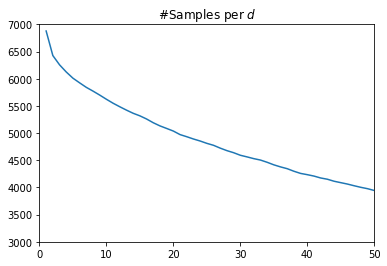

In [460]:
dist_5 = date.groupby('dist_5').Response.agg(['mean', 'sum', 'count'])
plt.plot(dist_5.index, dist_5['count'])
plt.axis([0, 50, 3000, 7000])
plt.title('#Samples per $d$')
plt.show()

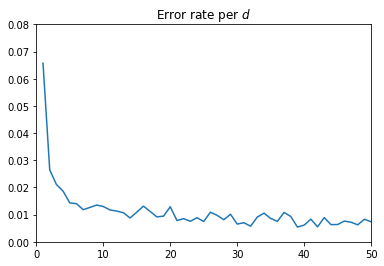

In [457]:
plt.plot(dist_5.index, dist_5['mean'])
plt.axis([0, 50, 0, 0.08])
plt.title('Error rate per $d$')
plt.show()

### Row distance to next error when sorted by start date and ID
$P(\text{error}\mid d=1)=0.065$, $d$ is the next distance.

It's the same as row distance to previous error. This means that the error distribution around an existing error is symmetric. This is actually obvious, because **a pair of errors contribute to the distribution on two sides symmetrically**.

In [489]:
date['dist_6'] = 9999999*np.ones(len(date), dtype=int)
date.loc[date.Response==1, 'dist_6'] = date.index[date.Response==1]
date['dist_6'] = date['dist_6'].shift(-1).fillna(9999999).astype(int)

date['dist_6'] = date['dist_6'].iloc[::-1].cummin().iloc[::-1] - date.index

In [492]:
date.groupby('dist_6').Response.agg(['mean', 'sum', 'count']).head()

,mean,sum,count
dist_6,,,
1,0.065726,452,6877
2,0.026459,170,6425
3,0.021103,132,6255
4,0.018618,114,6123
5,0.014312,86,6009


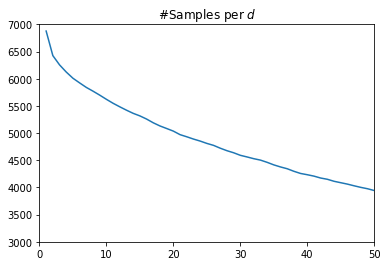

In [494]:
dist_6 = date.groupby('dist_6').Response.agg(['mean', 'sum', 'count'])
plt.plot(dist_6.index, dist_6['count'])
plt.axis([0, 50, 3000, 7000])
plt.title('#Samples per $d$')
plt.show()

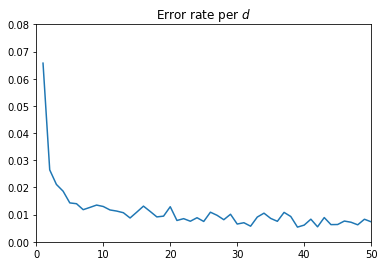

In [495]:
plt.plot(dist_6.index, dist_6['mean'])
plt.axis([0, 50, 0, 0.08])
plt.title('Error rate per $d$')
plt.show()

### Time and frequency analysis

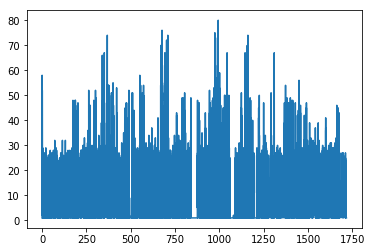

In [800]:
# Groupby time points
x = date.groupby('date_start').Response.agg(['mean', 'sum', 'count']).sort_values(['count'], ascending=False)
x.sort_index(inplace=True)

plt.plot(x.index, x['count'])

But time intervals are not uniform

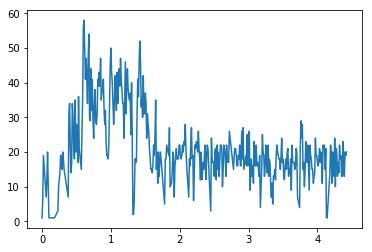

In [801]:
N = 400
plt.plot(x.index[:N], x['count'].values[:N])

So we need to first interpolate the sequence to uniform intervals

C:\Users\home\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


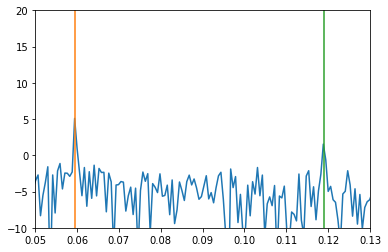

In [802]:
import scipy.fftpack

t = np.arange(x.index.min(), x.index.max(), 0.01) # time axis
x_counts = np.interp(t, x.index, x['count']) # interpolated part counts 
x_error_rate = np.interp(t, x.index, x['mean']) # interpolated part error rate
x_errors = np.interp(t, x.index, x['sum']) # interpolated part error

N = t.shape[0] # total number of time points
T = 0.01 # time interval
f = np.linspace(0.0, 1.0/(2.0*T), N/2) # frequency axis

y_counts = scipy.fftpack.fft(x_counts) # fft of x_counts
y_errors = scipy.fftpack.fft(x_errors) # fft of x_errors
y_error_rate = scipy.fftpack.fft(x_error_rate) # fft of x_error_rate
plt.plot(f, 10*np.log10(2.0/N * np.abs(y_counts[:N//2]))) # plot frequency 
plt.axis([0.05, 0.13, -10.0, 20.0]) # zoom in
plt.plot([0.0595, 0.0595], [-10, 20])
plt.plot([0.119, 0.119], [-10, 20])

We find two nontrivial peaks at round 0.06 and 0.12, indicating one repeated pattern in `x_counts`. The inverse of the frequency is $1/0.06=16.7$, which resembles the number of hours per week (168 hours). And $1/16.8=0.0595$ is exactly the frequency of the first peak.

So we conclude that the time scale is 10 hours/unit. The whole data set has 1716.53 time units, equivalent to 102.1 weeks,  or 715.2 days, or 2 years.

Let us rescale time axis.

Text(0.5,1,'A weekend')

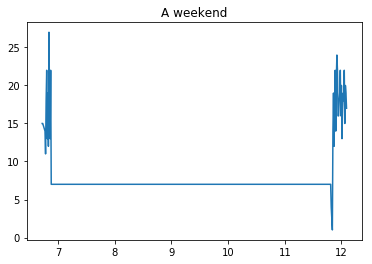

In [804]:
M = 1680 # this is one week's samples
# N1 = int(M*1 + 1.65*M/7)
# N2 = int(M*1 + 2.3*M/7)
N1 = int(M*0+0.40*M)
N2 = int(M*0+0.72*M)
plt.plot(t[N1:N2+1], x_counts[N1:N2+1])
plt.title('A weekend')

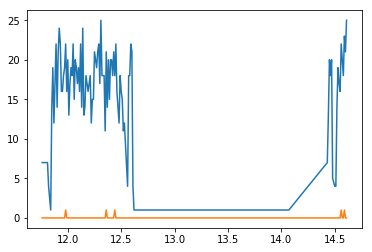

In [806]:
M = 1680
# N1 = int(M*1 + 1.65*M/7)
# N2 = int(M*1 + 2.3*M/7)
N1 = int(M*0+0.70*M)
N2 = int(M*0+0.87*M)
plt.plot(t[N1:N2+1], x_counts[N1:N2+1])
plt.plot(t[N1:N2+1], x_errors[N1:N2+1])

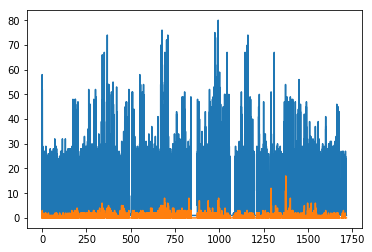

In [807]:
M = 1680
# N1 = int(M*1 + 1.65*M/7)
# N2 = int(M*1 + 2.3*M/7)
N1 = int(M*0+0.0*M)
N2 = int(M*180+0.0*M)
plt.plot(t[N1:N2+1], x_counts[N1:N2+1])
plt.plot(t[N1:N2+1], x_errors[N1:N2+1])
# plt.axis([-1, 65, 0, 30])

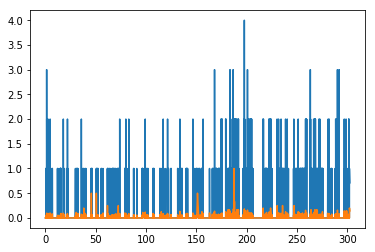

In [808]:
M = 1680
# N1 = int(M*1 + 1.65*M/7)
# N2 = int(M*1 + 2.3*M/7)
N1 = int(M*0+0.0*M)
N2 = int(M*18+0.0*M)
plt.plot(t[N1:N2+1], x_errors[N1:N2+1])
plt.plot(t[N1:N2+1], x_error_rate[N1:N2+1])
# plt.axis([-1, 65, 0, 30])

**But no pattern in error and error rate**

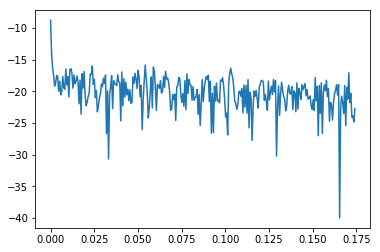

In [809]:
Ns = 300
plt.plot(f[:Ns], 10*np.log10(2.0/N * np.abs(y_errors[:Ns]))) # plot frequency 

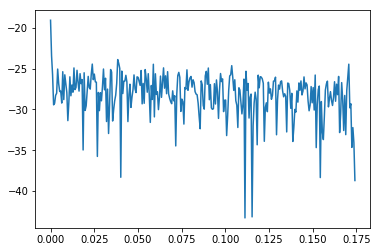

In [810]:
Ns = 300
plt.plot(f[:Ns], 10*np.log10(2.0/N * np.abs(y_error_rate[:Ns]))) # plot frequency 

### Analysis of end time
Previously we analyzed the start time of each part, let's also look at the end time.

In [811]:
z = date.groupby('date_end').Response.agg(['mean', 'sum', 'count']).sort_values(['count'], ascending=False)
z.sort_index(inplace=True)

z_counts = np.interp(t, z.index, z['count']) # interpolated part counts 
z_error_rate = np.interp(t, z.index, z['mean']) # interpolated part error rate
z_errors = np.interp(t, z.index, z['sum']) # interpolated part error

Time domain start and end time series

In [829]:
locs

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

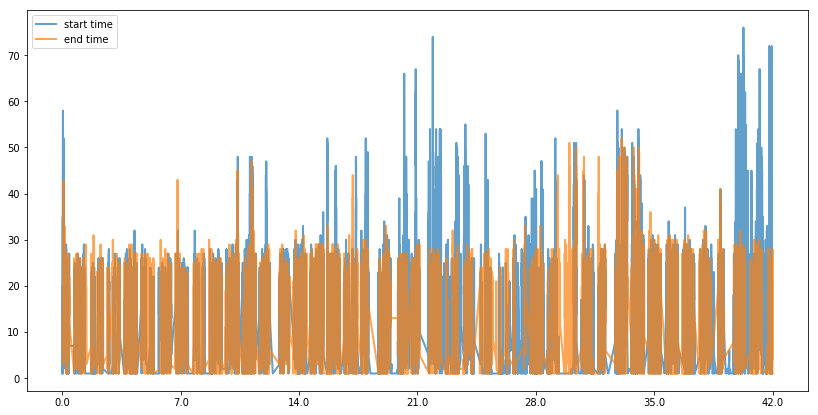

In [847]:
M = 1680 # 16.8 time units
# N1 = int(M*1 + 1.65*M/7)
# N2 = int(M*1 + 2.3*M/7)
N1 = int(M*0+0.0*M)
N2 = int(M*42+0.0*M)

plt.figure(figsize=(14,7))
line1 = plt.plot(t[N1:N2+1], x_counts[N1:N2+1], label='start time')
line2 = plt.plot(t[N1:N2+1], z_counts[N1:N2+1], label='end time')
plt.setp(line1, alpha=0.7, linewidth=2)
plt.setp(line2, alpha=0.7, linewidth=2)
# plt.xticks(locs=np.arange(0, N2, N2/42), labels=np.arange(0, 42, 1))
locs = np.arange(0, 16.8*49, 16.8*7)
plt.xticks(locs, ['{:.1f}'.format(n*10/168) for n in locs])
plt.legend()

In [848]:
zf_counts = scipy.fftpack.fft(z_counts) # fft of x_counts
zf_errors = scipy.fftpack.fft(z_errors) # fft of x_errors
zf_error_rate = scipy.fftpack.fft(z_error_rate) # fft of x_error_rate

**End time has more patterns**

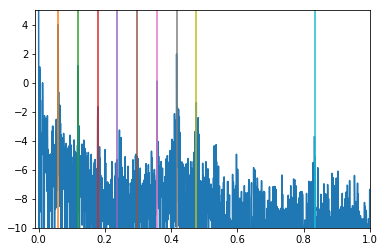

In [849]:
Ns = 3000
plt.plot(f[:Ns], 10*np.log10(2.0/N * np.abs(zf_counts[:Ns]))) # plot frequency 
plt.axis([-0.01, 1., -10, 5])
plt.plot([0.0595, 0.0595], [-10, 20])
plt.plot([0.119, 0.119], [-10, 20])
plt.plot([0.0595*3, 0.0595*3], [-10, 20])
plt.plot([0.0595*4, 0.0595*4], [-10, 20])
plt.plot([0.0595*5, 0.0595*5], [-10, 20])
plt.plot([0.0595*6, 0.0595*6], [-10, 20])
plt.plot([0.0595*7, 0.0595*7], [-10, 20]) # 7 weeks frequency is very strong
plt.plot([0.0595*8, 0.0595*8], [-10, 20])
plt.plot([0.0595*14, 0.0595*14], [-10, 20]) # 14 weeks frequency 

### Difference between neighboring time points

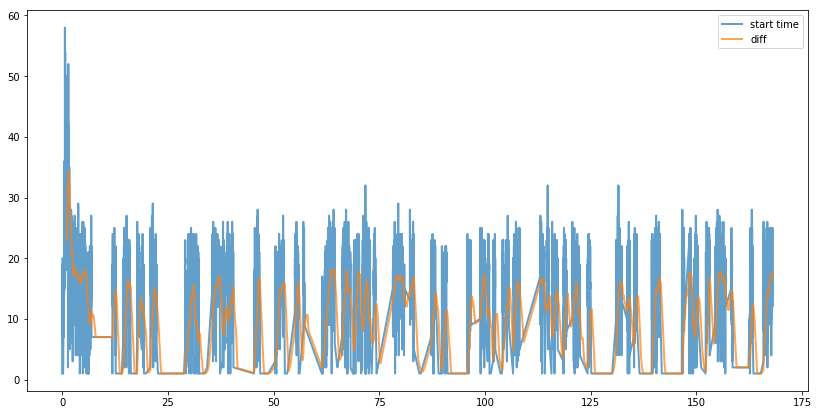

In [928]:
ser = pd.Series(x_counts, index=t)
x_counts_mean = ser.rolling(window=100, win_type='boxcar').mean().values

M = 1680 # 16.8 time units
N1 = int(M*0+0.0*M)
N2 = int(M*10+0.0*M)

plt.figure(figsize=(14,7))
line1 = plt.plot(t[N1:N2+1], x_counts[N1:N2+1], label='start time')
line2 = plt.plot(t[N1:N2+1], x_counts_mean[N1:N2+1], label='diff')
plt.setp(line1, alpha=0.7, linewidth=2)
plt.setp(line2, alpha=0.7, linewidth=2)
# locs = np.arange(0, 16.8*1, 16.8*7)
# plt.xticks(locs, ['{:.1f}'.format(n*10/168) for n in locs])
plt.legend()

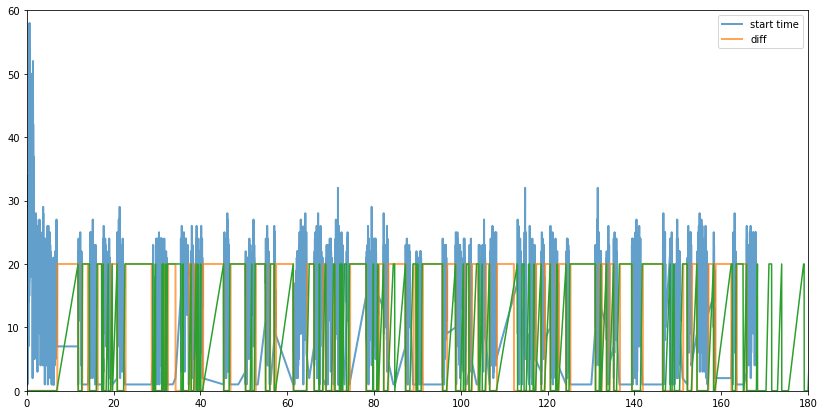

In [935]:
ser = pd.Series(x_counts, index=t)
x_counts_diff = ser.diff().abs().fillna(1)
# x_counts_diff = x_counts_diff[x_counts_diff<0.01].values
th = 0.1
a = x_counts_diff<th
b = (x_counts_diff>=th) | (x_counts>15)
x_counts_diff[a] = 20
x_counts_diff[b] = 0
x_counts_diff = x_counts_diff.rolling(window=15, win_type='boxcar').mean()
x_counts_diff[x_counts_diff<19] = 0
x_counts_diff = x_counts_diff.values

u = x.reset_index()
u['diff'] = u.date_start.diff().fillna(0.01)
u1 = u['diff']<0.1
u2 = u['diff']>=0.1
u.loc[u1, 'diff'] = 0
u.loc[u2, 'diff'] = 20

M = 1680 # 16.8 time units
N1 = int(M*0+0.0*M)
N2 = int(M*10+0.0*M)

plt.figure(figsize=(14,7))
line1 = plt.plot(t[N1:N2+1], x_counts[N1:N2+1], label='start time')
line2 = plt.plot(t[N1:N2+1], x_counts_diff[N1:N2+1], label='diff')
line3 = plt.plot(u['date_start'].values, u['diff'].values)
plt.setp(line1, alpha=0.7, linewidth=2)
plt.setp(line2, alpha=0.7, linewidth=2)
# locs = np.arange(0, 16.8*1, 16.8*7)
# plt.xticks(locs, ['{:.1f}'.format(n*10/168) for n in locs])
plt.axis([0, 180, 0, 60])
plt.legend()

## Histogram based on position in a week
By plotting the histograms counts, errors, and error rates of start and finish time during the week, we can identify weekends and workdays, and distribution of errors in a week.

- Parts never finish during a certain period in a week, this should be weekends.
- At the last hour of Fridays, weekends, the first hour of Mondays, and some other times have high error rates.
- Clear patterns in finish time, indicating days during a week.

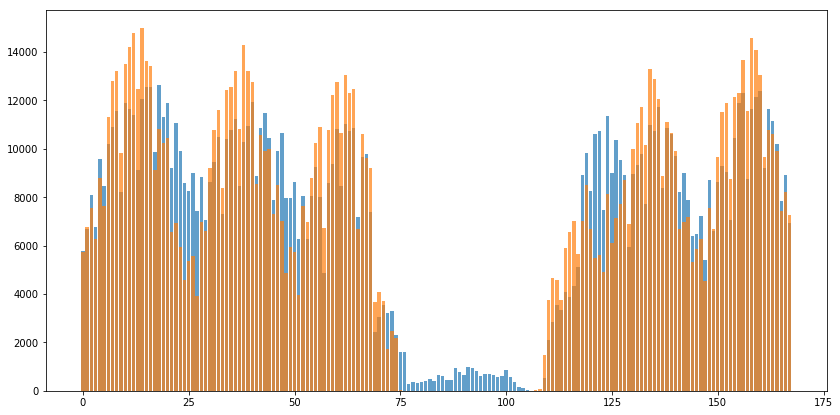

In [999]:
Nm = 1
tmp = (date['date_start'] % (16.8 * Nm))/(16.8*Nm)*168
date['date_start_mod1'] = tmp.values.astype(int)
a = date.groupby('date_start_mod1').Response.agg(['mean', 'sum', 'count'])
a.reset_index(inplace=True)
a.sort_values('date_start_mod1', ascending=True)

tmp = (date['date_end'] % (16.8 * Nm))/(16.8*Nm)*168
date['date_end_mod1'] = tmp.values.astype(int)
b = date.groupby('date_end_mod1').Response.agg(['mean', 'sum', 'count'])
b.reset_index(inplace=True)
b.sort_values('date_end_mod1', ascending=True)

# plt.plot(a['count']/10000)
# plt.plot(a['sum']/100)
fig = plt.figure(figsize=(14, 7))
plt.bar(a['date_start_mod1'], a['count'], alpha=0.7)
plt.bar(b['date_end_mod1'], b['count'], alpha=0.7)
# plt.plot(b['count']*10**-6)
plt.show()

### Distribution of production duration 

[-1, 30, 0, 800000]

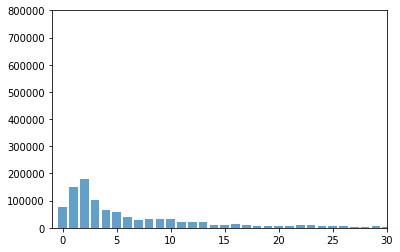

In [1009]:
dmin = date['date_duration'].min()
dmax = date['date_duration'].max()
tmp = (date['date_duration'] - dmin) / (dmax - dmin) * 1000
date['date_duration_bin1'] = tmp.values.astype(int)
c = date.groupby('date_duration_bin1').Response.agg(['mean', 'sum', 'count'])
c.reset_index(inplace=True)
c.sort_values('date_duration_bin1', ascending=True)
plt.bar(c['date_duration_bin1'], c['count'], alpha=0.7)
plt.axis([-1, 30, 0, 800000])